# Fake News XAI — Live Demo

This notebook loads the fine-tuned DistilBERT Kaggle model, runs a live prediction on a user-provided statement, and visualizes explanations (IG, LIME, SHAP) and last-layer attention.


In [64]:
# Cell 1 – Imports and paths

from pathlib import Path
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

# Optional: these libraries should already be installed in your env
from captum.attr import IntegratedGradients
from lime.lime_text import LimeTextExplainer
import shap

# Person-1 style plotting defaults
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
MODEL_DIR = ARTIFACTS_DIR / "distilbert" / "kaggle" / "final_model"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Model directory: {MODEL_DIR}")


Using device: cuda
Model directory: /home/anton/projects/CP322_fake_news_xai/artifacts/distilbert/kaggle/final_model


## Utilities

Helper functions for loading the model, predicting, plotting token importances, and running IG / LIME / SHAP on a single input.


In [65]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients
from lime.lime_text import LimeTextExplainer
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ---------- Prediction helper ----------

def predict_single(text, model, tokenizer, max_length=256):
    """
    Run a single-text prediction through DistilBERT and return:
    - pred_id: int
    - conf: float (probability of predicted class)
    - probs: np.ndarray of shape (num_classes,)
    """
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        out = model(**enc)
        logits = out.logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    pred_id = int(np.argmax(probs))
    conf = float(probs[pred_id])
    return pred_id, conf, probs


# ---------- Shared plotting helper (Person 1 style) ----------

def plot_token_importances(tokens, scores, title, color="#3498db", top_k=15):
    """
    Horizontal bar chart in the same visual style as Person 1's EDA plots.
    - tokens: list[str]
    - scores: 1D np.array or list[float]
    - top_k: number of tokens to show (by |score|)
    """
    scores = np.asarray(scores, dtype=float)

    # Filter out special tokens
    filtered = [
        (tok, s)
        for tok, s in zip(tokens, scores)
        if tok not in ("[CLS]", "[SEP]", "[PAD]")
    ]
    if not filtered:
        print("No tokens to plot (after filtering special tokens).")
        return

    tokens_f, scores_f = zip(*filtered)
    tokens_f = list(tokens_f)
    scores_f = np.array(scores_f)

    # Select top_k by absolute value, but keep original order
    if top_k is not None and len(tokens_f) > top_k:
        idx_sorted = np.argsort(-np.abs(scores_f))
        top_idx = sorted(idx_sorted[:top_k])
        tokens_f = [tokens_f[i] for i in top_idx]
        scores_f = scores_f[top_idx]

    y_pos = np.arange(len(tokens_f))

    fig, ax = plt.subplots(figsize=(10, 0.5 * len(tokens_f) + 2))

    # Color by sign: positive vs negative
    bar_colors = [
        color if s >= 0 else "#e74c3c"
        for s in scores_f
    ]

    ax.barh(y_pos, scores_f, color=bar_colors,
            edgecolor='black', linewidth=1.2)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(tokens_f, fontsize=11)
    ax.invert_yaxis()  # highest score on top
    ax.set_xlabel("Importance", fontsize=12, fontweight="bold")
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


# ---------- Integrated Gradients ----------

def explain_with_ig(text, model, tokenizer, max_length=256, n_steps=32):
    """
    Integrated Gradients over input embeddings.
    Returns (tokens, scores) where:
    - tokens: tokenizer.convert_ids_to_tokens(...)
    - scores: np.array of per-token IG attributions (sum over hidden dim)
    """
    model.eval()

    # Tokenize
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    # Get embeddings
    emb_layer = model.get_input_embeddings()
    embeds = emb_layer(input_ids)  # (1, seq_len, hidden_dim)
    baseline = torch.zeros_like(embeds)

    # Predicted class
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=-1)[0]
        pred_id = int(torch.argmax(probs).item())

    def forward(embeds_):
        # embeds_: (bs, seq_len, hidden_dim)
        bsz = embeds_.shape[0]
        attn = attention_mask.expand(bsz, -1)
        out = model(inputs_embeds=embeds_, attention_mask=attn)
        probs_ = torch.softmax(out.logits, dim=-1)
        return probs_[:, pred_id]

    ig = IntegratedGradients(forward)
    attributions = ig.attribute(
        inputs=embeds,
        baselines=baseline,
        n_steps=n_steps,
    )
    # Sum over hidden dim -> scalar per token
    token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    return tokens, token_scores


# ---------- LIME ----------

def explain_with_lime(
    text,
    model,
    tokenizer,
    max_length=256,
    num_features=15,
    num_samples=500,
):
    """
    Run LIME on a single text.

    Returns (tokens, scores) where tokens are LIME's text tokens and
    scores are per-token LIME weights for the predicted class.
    """
    model.eval()
    class_names = ["FAKE", "REAL"]
    explainer = LimeTextExplainer(class_names=class_names, bow=True)

    def lime_predict(texts):
        enc = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        return probs

    # Get prediction so we know which class to explain
    probs_single = lime_predict([text])[0]
    pred_id = int(np.argmax(probs_single))

    explanation = explainer.explain_instance(
        text_instance=text,
        classifier_fn=lime_predict,
        num_features=num_features,
        num_samples=num_samples,
        labels=(pred_id,),
    )

    # Stable LIME API: as_list(label=pred_id) -> [(token, weight), ...]
    items = explanation.as_list(label=pred_id)
    tokens = [w for (w, _) in items]
    scores = np.array([s for (_, s) in items], dtype=float)

    return tokens, scores


# ---------- SHAP ----------

def make_shap_explainer(model, tokenizer, max_length: int = 256):
    """
    Build a SHAP explainer around the DistilBERT model and tokenizer.
    This version is robust to the various array-like formats SHAP passes in.
    """
    device = next(model.parameters()).device
    model.eval()

    def shap_predict(texts):
        """
        texts can be:
          - a single string
          - a list/tuple of strings
          - a numpy array of strings or objects
          - nested arrays coming from the Text masker

        We normalize everything into a flat list[str] before tokenization.
        """
        # Normalize to a flat Python list of strings
        if isinstance(texts, str):
            batch_texts = [texts]
        elif isinstance(texts, (list, tuple)):
            # Could be list of strings or list of arrays
            batch_texts = []
            for t in texts:
                if isinstance(t, (list, tuple, np.ndarray)):
                    # Flatten nested stuff and cast to str
                    batch_texts.extend([str(x) for x in np.array(t).ravel().tolist()])
                else:
                    batch_texts.append(str(t))
        elif isinstance(texts, np.ndarray):
            # SHAP often passes np.ndarray
            # Flatten and cast to str
            batch_texts = [str(x) for x in texts.ravel().tolist()]
        else:
            # Fallback: single object → string
            batch_texts = [str(texts)]

        # Tokenize
        enc = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        return probs

    # Let SHAP create a Text masker internally from the tokenizer
    masker = shap.maskers.Text(tokenizer) # type: ignore
    explainer = shap.Explainer(shap_predict, masker)

    return explainer


def explain_with_shap(
    text: str,
    shap_explainer,
    max_evals: int = 5000,
    drop_special: bool = True,
):
    """
    Run SHAP on a single text and return (tokens, scores).

    - Uses the already-built `shap_explainer`.
    - Assumes a DistilBERT-style classifier with logits over classes.
    """
    shap_values = shap_explainer([text], max_evals=max_evals)

    # Tokens (as strings) from SHAP's text masker
    tokens = list(shap_values.data[0])

    # Values: shape can be (seq_len, num_classes) or (seq_len,)
    values = shap_values.values[0]
    if values.ndim == 2:
        # Choose class with maximum L1 importance (or pick argmax predicted)
        # Here we pick the class with max |sum(values)|
        class_idx = int(np.argmax(np.sum(np.abs(values), axis=0)))
        scores = values[:, class_idx]
    else:
        scores = values

    scores = np.array(scores, dtype=float)

    if drop_special:
        keep_idx = [
            i for i, tok in enumerate(tokens)
            if tok not in ("[CLS]", "[SEP]", "[PAD]")
        ]
        tokens = [tokens[i] for i in keep_idx]
        scores = scores[keep_idx]

    return tokens, scores.tolist()



# ---------- Last-layer CLS attention ----------

def get_last_layer_cls_attention(text, model, tokenizer, max_length=256):
    """
    Return (tokens, scores) where scores are last-layer mean-head
    attention weights from [CLS] to each token.
    """
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc, output_attentions=True)

    # outputs.attentions: tuple (n_layers, batch, n_heads, seq_len, seq_len)
    last_attn = outputs.attentions[-1][0]    # (n_heads, seq_len, seq_len)
    cls_to_tok = last_attn.mean(dim=0)[0]    # (seq_len,)

    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    scores = cls_to_tok.detach().cpu().numpy()

    return tokens, scores


Using device: cuda


## Load DistilBERT Kaggle model

Load the fine-tuned Kaggle model and set up LIME and SHAP explainers.


In [66]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model from local artifacts
tokenizer = AutoTokenizer.from_pretrained(str(MODEL_DIR))
model = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR))
model.to(device)
model.eval()

# Label mapping
if getattr(model.config, "id2label", None):
    id2label = {int(k): v for k, v in model.config.id2label.items()}
else:
    id2label = {0: "fake", 1: "real"}

print("Loaded model from:", MODEL_DIR)
print("id2label:", id2label)

# Build SHAP explainer once (can take a bit)
print("Building SHAP explainer (this may take a moment)...")
shap_explainer = shap_explainer = make_shap_explainer(model, tokenizer, max_length=256)

print("SHAP explainer ready.")


Loaded model from: /home/anton/projects/CP322_fake_news_xai/artifacts/distilbert/kaggle/final_model
id2label: {0: 'LABEL_0', 1: 'LABEL_1'}
Building SHAP explainer (this may take a moment)...
SHAP explainer ready.


## Enter a statement and get prediction

Provide a news story and see the model’s prediction and confidence.


In [67]:
# Cell 4 – User input and prediction

# user_text = input("Enter a statement/headline: ").strip()
user_text = ""  # For testing in notebook
if not user_text:
    user_text = """

Campbell's is an institution, and all of us likely have memories of growing up eating it, or possibly still enjoying a bowl or two of its soups today. However, earlier this week, Campbell's was thrown into the spotlight after reported leaked audio surfaced of a company executive mocking both the food and the people who buy it.
Three Campbell's Chicken Noodle Soup cans are lined up side by side

ShutterWorx / Getty Images
This all started after a former Campbell's employee filed a lawsuit claiming he was let go for reporting offensive behavior by a senior executive. The employee, Robert Garza, claims he recorded a 2024 meeting in which, allegedly, Martin Bally — the company's vice president and chief information security officer — criticized Campbell's products and made derogatory remarks about colleagues. In the recording, Bally allegedly called Campbell's soups "highly process(ed)" and suggested they were meant for "poor people." Garza also claims Bally made racist comments about Indian employees during the same conversation.
Campbell's soup cans, including Chicken Noodle, Vegetable Beef, and Cream of Mushroom, are displayed on a store shelf with visible price tags

Spencer Platt / Getty Images
According to the suit, Garza reported what he heard to his supervisor, but a few weeks later, on Jan. 30, 2025, he was suddenly fired without warning. He argues the timing wasn't a coincidence and that the company retaliated against him for speaking up. Campbell's placed Bally on leave* after the lawsuit became public and said the behavior described in the filings doesn't reflect the company's values. The company also said it wasn't aware of the recording until it was released and pushed back on Bally's alleged claims about it using "3-D printed meat," noting that its products use real, USDA-approved chicken.
Cans of Campbell's soup, including Spicy Nacho Cheese and Chicken with Rice, displayed on a grocery store shelf

Scott Olson / Getty Images

*Campbell's announced that Bally left the company today.
It would be damaging for any company to have comments like this surface, but the timing makes it sting even more. Many families are already dealing with food insecurity, and pantry staples like Campbell's soup are often what people rely on when money is tight. And with the holidays coming up — when items like Cream of Mushroom Soup are essential for dishes like green bean casserole — hearing an executive mock the products and the people who use them has landed especially hard.

Hand holds a can of Campbell's Cream of Mushroom soup, labeled &quot;Great for Cooking.&quot;

Thinglass / Getty Images
It's probably no surprise that the leaked audio has left people shocked and more than a little angry. The reaction online was immediate, with many users calling out how out of touch the remarks sounded. So I pulled together some of the standout responses on X to capture how people are feeling about the whole situation: 

"""

user_text = user_text.strip()
print("\nYour input:")
print(user_text)

# Predict
pred_id, conf, probs = predict_single(user_text, model, tokenizer, max_length=256)

# Map to clean FAKE / REAL label
raw_label = str(id2label.get(pred_id, pred_id))
norm = raw_label.upper()

if "FAKE" in norm or norm.endswith("_0") or norm == "0":
    label_name = "FAKE"
elif "REAL" in norm or norm.endswith("_1") or norm == "1":
    label_name = "REAL"
else:
    label_name = raw_label.upper()

print(f"\nPredicted label: {label_name} (class {pred_id})")
print(f"Confidence: {conf:.3f}")
print("Class probabilities:")
for i, p in enumerate(probs):
    pretty = "FAKE" if i == 0 else "REAL" if i == 1 else id2label.get(i, str(i))
    print(f"  {pretty}: {p:.3f}")


Your input:
Campbell's is an institution, and all of us likely have memories of growing up eating it, or possibly still enjoying a bowl or two of its soups today. However, earlier this week, Campbell's was thrown into the spotlight after reported leaked audio surfaced of a company executive mocking both the food and the people who buy it.
Three Campbell's Chicken Noodle Soup cans are lined up side by side

ShutterWorx / Getty Images
This all started after a former Campbell's employee filed a lawsuit claiming he was let go for reporting offensive behavior by a senior executive. The employee, Robert Garza, claims he recorded a 2024 meeting in which, allegedly, Martin Bally — the company's vice president and chief information security officer — criticized Campbell's products and made derogatory remarks about colleagues. In the recording, Bally allegedly called Campbell's soups "highly process(ed)" and suggested they were meant for "poor people." Garza also claims Bally made racist commen

## IG, LIME, and SHAP explanations

Run all three explanation methods on the same input and visualize token importances with consistent styling.


Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


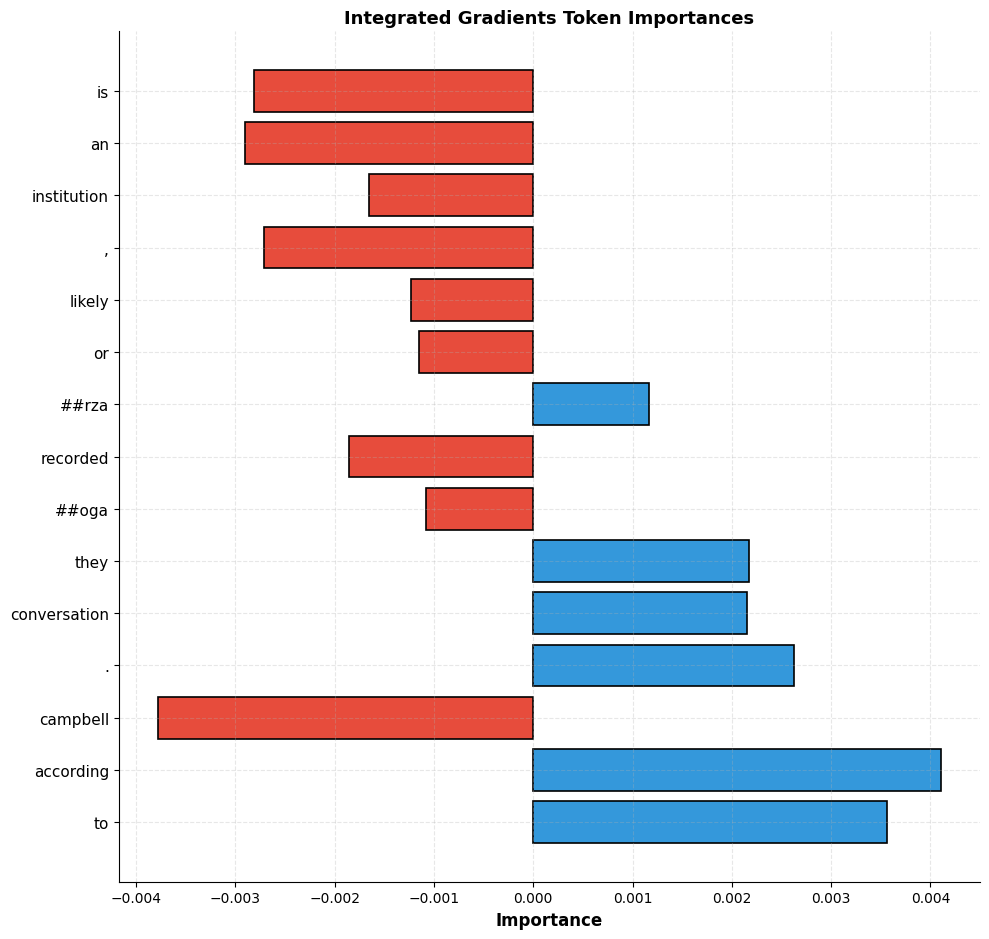

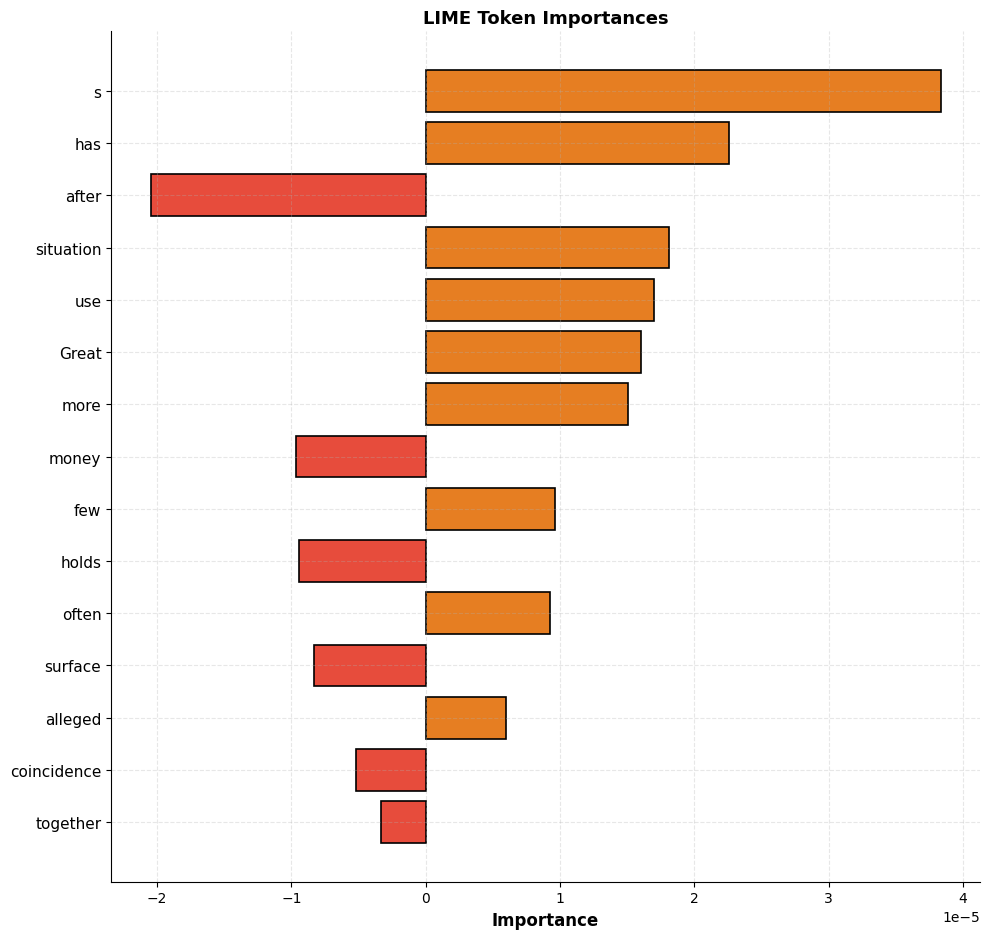

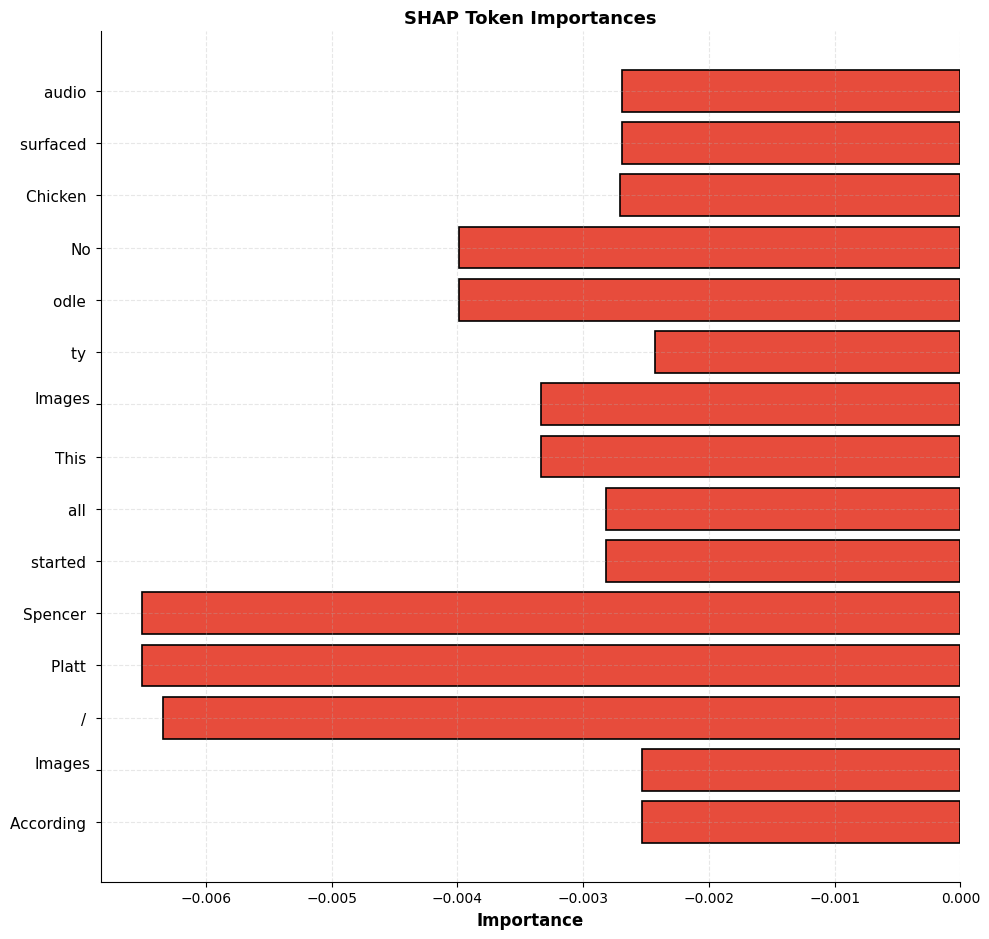

In [68]:
# Integrated Gradients
tokens_ig, scores_ig = explain_with_ig(
    user_text,
    model,
    tokenizer,
    max_length=256,
    n_steps=32,
)

# LIME
tokens_lime, scores_lime = explain_with_lime(
    user_text,
    model,
    tokenizer,
    max_length=256,
    num_features=15,
    num_samples=500,
)

# SHAP
tokens_shap, scores_shap = explain_with_shap(
    user_text,
    shap_explainer,
    max_evals=2000,   # you can lower this for speed in the demo
)

# Plot all three with consistent styling
plot_token_importances(
    tokens_ig,
    scores_ig,
    title="Integrated Gradients Token Importances",
    color="#3498db",
    top_k=15,
)

plot_token_importances(
    tokens_lime,
    scores_lime,
    title="LIME Token Importances",
    color="#e67e22",
    top_k=15,
)

plot_token_importances(
    tokens_shap,
    scores_shap,
    title="SHAP Token Importances",
    color="#9b59b6",
    top_k=15,
)


## Last-layer attention visualization

Visualize how much attention the last transformer layer’s [CLS] token puts on each token in the input.


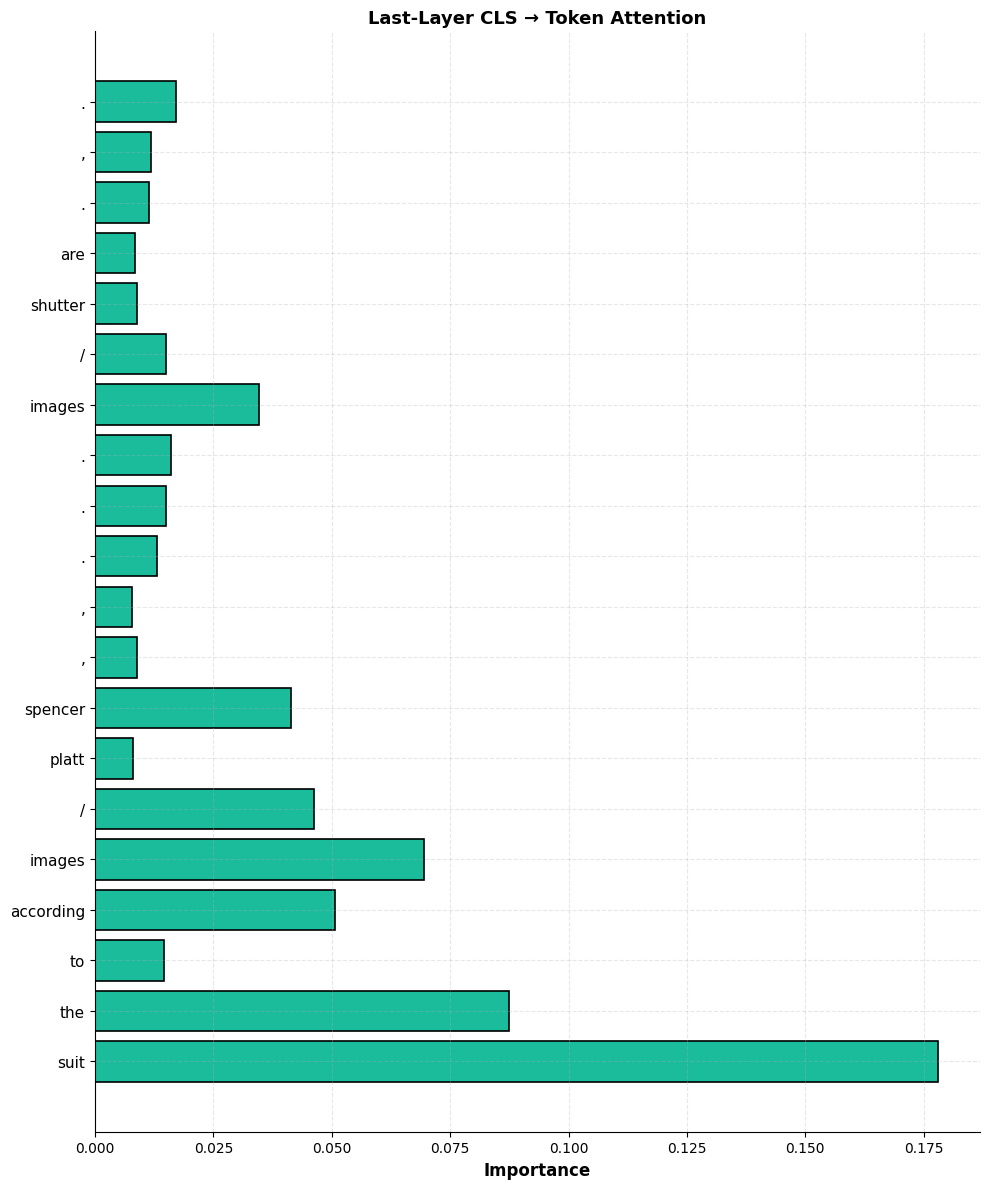

In [69]:
tokens_attn, scores_attn = get_last_layer_cls_attention(
    user_text,
    model,
    tokenizer,
    max_length=256,
)

plot_token_importances(
    tokens_attn,
    scores_attn,
    title="Last-Layer CLS → Token Attention",
    color="#1abc9c",
    top_k=20,
)
